<a href="https://colab.research.google.com/github/gn96311/Geon_Repository/blob/master/Denoising_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os, re, glob
import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageMath
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
Dataset_dir = os.getcwd() + '/drive/My Drive/Colab/Data'

In [4]:
print(Dataset_dir)

/content/drive/My Drive/Colab/Data


# Image to Patches

In [5]:
def image_to_patches(img_pad, stride_x, stride_y, mini_batch_size = 32):
    PATCH_SHAPE = (135, 135, 3)
    H, W, C = img_pad.shape
    batches = None

    num_patches_x = (W - PATCH_SHAPE[1]) / stride_x + 1
    num_patches_y = (H - PATCH_SHAPE[0]) / stride_y + 1

    total_patches = int(num_patches_x * num_patches_y)
    res = int(total_patches % mini_batch_size)

    batches = np.zeros((total_patches, *PATCH_SHAPE))

    x = y = 0
    for n in range(total_patches):
        patch = np.array([img_pad[y:y+PATCH_SHAPE[1], x:x+PATCH_SHAPE[0], :]])
        assert patch.shape == (1, *PATCH_SHAPE), "Shape mismatch, %s" % str(patch.shape)

        batches[n, :, :, :] = patch

        if x + PATCH_SHAPE[1] < W:
            x += stride_x

        elif x + PATCH_SHAPE[1] >= W and y + PATCH_SHAPE[0] < H:
            y += stride_y
            x = 0

        elif x + PATCH_SHAPE[1] >= W and y + PATCH_SHAPE[0] >= H:
            break

    if not res == 0:
        for i in range(mini_batch_size-res):
            batches = np.concatenate((batches, patch), axis=0)

    batches = batches.reshape(-1, mini_batch_size, PATCH_SHAPE[0], PATCH_SHAPE[1], PATCH_SHAPE[2])

    return batches, res

In [6]:
#img = Image.open(Dataset_dir + '/Mona.jpg')
#img = np.asarray(img)
#batches, res = image_to_patches(img, 135, 135)

# Save the patches to Folder

In [7]:
def save_img(input_image, height, width, image_number, mode="Noise"):
    image_number = ("{}".format(image_number)).zfill(3)
    figsize = (1, height/width) if height>=width else (width/height, 1)
    plt.figure(figsize=figsize)
    plt.imshow(input_image)
    plt.axis('off'), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
    plt.savefig('{}/{}.jpg'.format(Dataset_dir + "/" + mode, image_number), bbox_inces = 'tight', pad_inches = 0, dpi = height)

In [8]:
class Dataset_maker():
    def __init__(self, img_list):
        self.images_list = img_list
        assert len(np.shape(self.images_list)) == 5, "The shape of Image list is not 5D, this shape is {}".format(len(np.shape(self.images_list)))
        
    def write_img(self):
        image_number = 0
        with tqdm(total = np.shape(self.images_list)[0] * (np.shape(self.images_list[0])[0]), desc = 'Loading') as pbar:
            for batch_number in range(np.shape(self.images_list)[0]):
                for images in self.images_list[batch_number]:
                    image_number += 1
                    clean_image = images/255.0
                    noise_image = clean_image + tf.random.poisson(clean_image.shape, 0.5)
                    save_img(clean_image, 135, 135, image_number, mode = 'Clean')
                    save_img(noise_image, 135, 135, image_number, mode = 'Noise')
                    pbar.update(1)

In [9]:
# dataset_make = Dataset_maker(batches)
# dataset_make.write_img()

# Image Show Functions

In [10]:
def noisy_imshow(image, ax=plt):
    fig = ax.figure(figsize = (10, 10))
    image = np.asarray(image)
    image = (image + 0.5) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [11]:
def clean_imshow(image, ax=plt):
    image = np.asarray(image)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [12]:
'''
x = train_set[0]
fig, axes = plt.subplots(ncols=2)
noisy_imshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
noisy_imshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')'''

"\nx = train_set[0]\nfig, axes = plt.subplots(ncols=2)\nnoisy_imshow(x[0], ax=axes[0])\naxes[0].set_title('Noisy')\nnoisy_imshow(x[1], ax=axes[1])\naxes[1].set_title('Clean')\nprint(f'image size is {x[0].shape}.')"

# Data Load Class

In [13]:
def read_image(x_path,y_path):
    x_image = tf.io.decode_image(tf.io.read_file(x_path), dtype=tf.float32)
    y_image = tf.io.decode_image(tf.io.read_file(y_path), dtype=tf.float32)
    return x_image, y_image

In [14]:
class Data_load():
    def __init__(self, batch_size, mode = 'train'):
        self.batch_size = batch_size
        self.mode = mode
        self.x_train_path = sorted(glob('/content/drive/My Drive/Colab/Data/Noise/*.jpg'))
        self.y_train_path = sorted(glob('/content/drive/My Drive/Colab/Data/Clean/*.jpg'))
        self.x_test_path = self.x_train_path
        self.y_test_path = self.y_train_path

    def make_dataset(self):
        if self.mode == 'train':
            dataset = tf.data.Dataset.from_tensor_slices((self.x_train_path, self.y_train_path))
            dataset = dataset.map(read_image)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.repeat()

        if self.mode == 'test':
            dataset = tf.data.Dataset.from_tensor_slices((self.x_test_path,self.y_test_path))
            dataset = dataset.map(read_image)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.repeat()
        
        return dataset

In [15]:
Generate_train_ds = Data_load(32, mode = 'train')
Generate_test_ds = Data_load(32, mode = 'test')

In [16]:
train_ds = Generate_train_ds.make_dataset()
test_ds = Generate_test_ds.make_dataset()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [17]:
x_test, y_test = read_image('/content/drive/My Drive/Colab/Data/Noise/001.jpg', '/content/drive/My Drive/Colab/Data/Clean/001.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tensorflow.python.framework.ops.EagerTensor'>


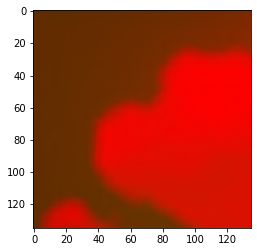

In [24]:
img = y_test
print(type(img))
img1 = tf.image.rgb_to_yuv(img)

plt.imshow(img1)

In [ ]:
class input_conv_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(input_conv_layer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, (3,3), padding = 'same', use_bias = False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, x, training=False, mask=None):
        return self.relu(self.bn(self.conv(x), training))

In [ ]:
class skip_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(skip_layer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(3, (3,3), padding = 'same', use_bias = False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
    
    def call(self, x, training = False, mask=None):
        return self.relu(self.bn(self.conv(x), training))

In [ ]:
class Multi_LSTM(tf.keras.layers.Layer):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same')
        self.conv2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same')
        self.convlstm = tf.keras.layers.ConvLSTM2D(32, (5,5), padding = 'same')
        
    
    def call(self, x, training = False, mask = None):
        # x = 1 32 32 64
        rot_0 = self.conv2(tf.expand_dims(x, axis=0)) # 1 1 32 32 32
        rot_90 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=1), axis=0))
        rot_180 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=2), axis=0))
        rot_270 = self.conv2(tf.expand_dims(tf.image.rot90(x, k=3), axis=0))
        
        convlstm1 = self.convlstm(rot_0)
        convlstm2 = self.convlstm(rot_90)
        convlstm3 = self.convlstm(rot_180)
        convlstm4 = self.convlstm(rot_270) # 1 32 32 32

        h_concat = tf.keras.layers.concatenate([convlstm1, convlstm2, convlstm3, convlstm4], axis = 0)
        h_concat = self.conv1(h_concat)
        print("concat: ", h_concat.shape)

        return h_concat

In [ ]:
class DeN_Model(tf.keras.Model):
    def __init__(self, channel = 64, DCNN_Layer = 15):
        super().__init__()
        self.input_conv = [input_conv_layer() for _ in range(DCNN_Layer)]
        self.skip = [skip_layer() for _ in range(DCNN_Layer)]
        self.lstm_list1 = Multi_LSTM()
        self.lstm_list2 = Multi_LSTM()
        self.lstm_list3 = Multi_LSTM()
        self.next_skip1 = skip_layer()
        self.next_skip2 = skip_layer()
        self.next_skip3 = skip_layer()
        self.conv2 = tf.keras.layers.Conv2D(3, (1,1), padding = 'same')
        self.conv = tf.keras.layers.Conv2D(3, (1,1), padding = 'same')
        self.conv3 = tf.keras.layers.Conv2D(3, (1,1), padding = 'same')
    
    def call(self, x, training = False, mask = None):
        first_input = x
        h_return = 0
        x = tf.expand_dims(x, axis = 0)
        for layer in range(15):
            h = self.input_conv[layer](x, training)
            h_skip = self.skip[layer](h, training)
            h_return = h_return + h_skip
        
        h = self.lstm_list1(h)
        h_skip = self.next_skip1(h, training)
        h_return = h_return + h_skip
        
        h = self.lstm_list2(h)
        h_skip = self.next_skip2(h, training)
        h_return = h_return + h_skip
        
        h = self.lstm_list3(h)
        h_skip = self.next_skip3(h, training)

        h_return = h_return + h_skip + first_input
        
        return h_return

In [ ]:
optimizer = tf.optimizers.Adam(1e-3)
Model = DeN_Model()
mean = tf.metrics.Mean()

#@tf.function
#def loss_function(y, y_):
#    return tf.keras.losses.MAE(y, y_)

@tf.function
def mse_loss(y, y_):
    return tf.keras.losses.MSE(y, y_)

@tf.function
def train_step(noise_img, clean_img, optimizer):
    with tf.GradientTape() as tape:
        denoising_img = Model(noise_img, training = True)
        
        loss = mse_loss(clean_img, denoising_img)
        
        gradients = tape.gradient(loss, Model.trainable_weights)
    
    optimizer.apply_gradients(zip(gradients, Model.trainable_weights))
    loss = tf.reduce_mean(loss)
    return loss

@tf.function
def test_step(noise_img, clean_img):
    denoising_img = Model(noise_img, training = False)

    loss = mse_loss(clean_img, denoising_img)
    return denoising_img

In [ ]:
i = 0
for epoch in range(1):
    for noise, clean in train_set:
        loss = train_step(noise, clean, optimizer)
        i += 1
        print(i)
        
        mean.update_state(loss)
    
    print('epoch: {}, loss: {}'.format(epoch+1, loss))

concat:  (4, 180, 180, 64)
concat:  (4, 180, 180, 64)
concat:  (4, 180, 180, 64)
1
epoch: 1, loss: 56.98060989379883


In [ ]:
Model.summary()

Model: "de_n__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_conv_layer_15 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_16 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_17 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_18 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_19 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_20 (input_c multiple                  1984      
_________________________________________________________________
input_conv_layer_21 (input_c multiple                

ValueError: ignored

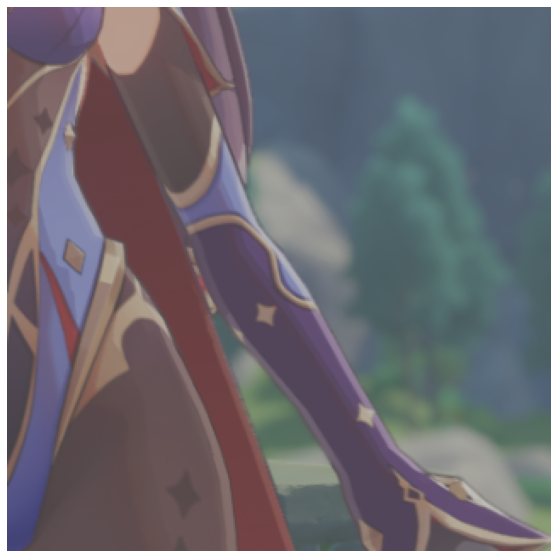

In [ ]:
x_test, y_test = test_set[-1]

noisy_imshow(y_test)

concat:  (4, 320, 320, 64)
concat:  (4, 320, 320, 64)
concat:  (4, 320, 320, 64)


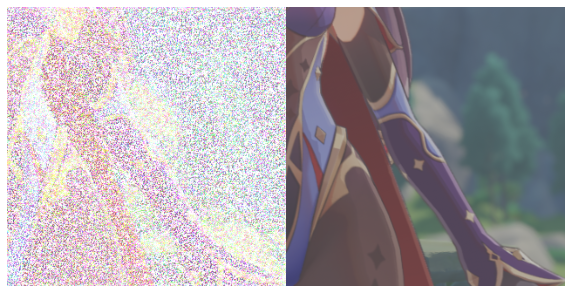

In [ ]:
denoised_img = test_step(x_test, y_test)
image_list = []
image_list.append(denoised_img[0])
image_list.append(y_test)
    
img = np.concatenate(image_list, axis=1)

noisy_imshow(img)

In [ ]:
Model.save_weights('/content/drive/My Drive/Colab/my_checkpoint')

AttributeError: ignored